In [1]:
%pylab inline
from richLowCost_copy import * 
Vgrid = np.load("richLow.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
t = 50
v,cbkha = vmap(partial(V,t,Vgrid[:,:,:,:,:,:,:,t+1]))(Xs)

CPU times: user 54.4 s, sys: 2.42 s, total: 56.8 s
Wall time: 14 s


In [3]:
from jax.scipy.optimize import minimize

In [14]:
# pc*qc / (ph*qh) = alpha/(1-alpha)
@partial(jit, static_argnums=(0,))
def feasibleActions(t, x, consumptionRatio, stockInvestingRatio):
    # owner
    sell = As[:,2]
    
    # last term is the tax deduction of the interest portion of mortgage payment
    payment = (x[2] > 0)*(((t<=T_R)*tau_L + (t>T_R)*tau_R)*x[2]*rh - m)
    sell = (yAT(t,x) + x[0] + payment > 0)*jnp.zeros(nA) + (yAT(t,x) + x[0] + payment <= 0)*jnp.ones(nA)
    budget1 = yAT(t,x) + x[0] + (1-sell)*payment + sell*(H*pt - x[2] - c_s)
    
    # last term is the tax deduction of the interest portion of mortgage payment    
#     consumptionRatio = As[:,0]*((t>=0 and t<20)*(2.0/3)) + As[:,0]*((t>=20 and t<40)*(1.0/3)) + As[:,0]*((t>=40 and t<=60)*(2.0/3))
    h = jnp.ones(nA)*H*(1+kappa)*(1-sell) + sell*jnp.clip(budget1*consumptionRatio*(1-alpha)/pr, a_max = Rl)
    c = budget1*consumptionRatio*(1-sell) + sell*(budget1*consumptionRatio - h*pr)
    budget2 = budget1*(1-consumptionRatio)
    # stock investing Ratio 
#     stockInvestingRatio = (As[:,1]*(100-(t+20))/100)
    k = budget2*stockInvestingRatio
    k = (k - (1-x[6])*(k>0)*c_k)*(1-Kc)
    b = budget2*(1-stockInvestingRatio)
    owner_action = jnp.column_stack((c,b,k,h,sell)) 
    
    
    # renter
    buy = As[:,2]*(t < 30)
    budget1 = yAT(t,x) + x[0] - buy*(H*pt*0.2 + c_h)
    h = jnp.clip(budget1*consumptionRatio*(1-alpha)/pr, a_max = Rl)*(1-buy) + buy*jnp.ones(nA)*H*(1+kappa)
    c = (budget1*consumptionRatio - h*pr)*(1-buy) + buy*budget1*consumptionRatio
    budget2 = budget1*(1-consumptionRatio)
    k = budget2*stockInvestingRatio
    k = (k - (1-x[6])*(k>0)*c_k)*(1-Kc)
    b = budget2*(1-stockInvestingRatio)
    renter_action = jnp.column_stack((c,b,k,h,buy))
    
    actions = x[5]*owner_action + (1-x[5])*renter_action
    return actions

@partial(jit, static_argnums=(0,))
def V(t,V_next,x):
    '''
    x = [w,n,m,s,e,o,z]
    x = [0,1,2,3,4,5]
    xp:
        w_next    0
        n_next    1
        m_next    2
        s_next    3
        e_next    4
        o_next    5
        z_next    6
        prob_next 7
    '''
    def Q(consumptionRatioStockInvestingRatio):
        actions = feasibleActions(t, x, jnp.exp(consumptionRatioStockInvestingRatio[0]), jnp.exp(consumptionRatioStockInvestingRatio[1]))
        xp = transition(t,actions,x)
        # bequeath utility
        TB = xp[:,0]+x[1]*(1+r_bar)+xp[:,5]*(H*pt-x[2]*(1+rh)-25)
        bequeathU = uB(TB)
        if t == T_max-1:
            QQ = R(x,actions) + beta * dotProduct(xp[:,7], bequeathU)
        else:
            QQ = R(x,actions) + beta * dotProduct(xp[:,7], Pa[t]*fit(V_next, xp) + (1-Pa[t])*bequeathU)
        QQ = jnp.nan_to_num(QQ, nan = -jnp.inf)
        v = QQ.max()
        return v
    return minimize(Q,jnp.array([0.5,0.5]),method = "BFGS")

In [15]:
t = 50
partial(V,t,Vgrid[:,:,:,:,:,:,:,t+1])(Xs[0])

The slowest run took 5.19 times longer than the fastest. This could mean that an intermediate result is being cached.
7.15 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
t = 50
partial(V,t,Vgrid[:,:,:,:,:,:,:,t+1])(Xs[2])

OptimizeResults(x=DeviceArray([0.5, 0.5], dtype=float32), success=DeviceArray(True, dtype=bool), status=DeviceArray(0, dtype=int32), fun=DeviceArray(-3.4028235e+38, dtype=float32), jac=DeviceArray([0., 0.], dtype=float32), hess_inv=DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32), nfev=DeviceArray(1, dtype=int32), njev=DeviceArray(1, dtype=int32), nit=DeviceArray(0, dtype=int32))

In [4]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates
import warnings
from jax import jit, partial, random, vmap
from tqdm import tqdm
warnings.filterwarnings("ignore")
detEarning = jnp.array(np.load("constant/detEarningHigh.npy"))
# rescale the deterministic income
detEarning = detEarning 
####################################################################################### low skill feature
lowDetEarning = jnp.concatenate([detEarning[:46]*0.5, detEarning[46:]-45])

In [5]:
####################################################################################### High skill feature
highDetEarning = jnp.concatenate([detEarning[:46], detEarning[46:]-35])

Populating the interactive namespace from numpy and matplotlib


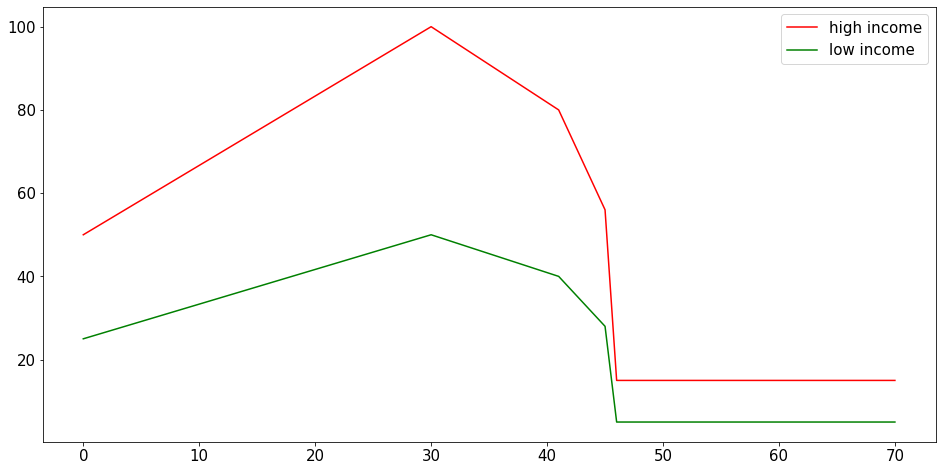

In [13]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})
plt.plot(highDetEarning, label = "high income", color ='r')
plt.plot(lowDetEarning, label = "low income", color = 'g')
plt.legend()
plt.savefig("artificialIncome")